## Importing required libraries and reading the dataset we balanced

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
# Downloading the balanced file via its file ID

file_id = '1xGAjSdbTJA7bLZklVxuGLiCm-sB2e260'

downloaded_path = f'/content/{file_id}.csv'

!gdown {file_id} --output {downloaded_path}

df = pd.read_csv(downloaded_path,low_memory=False)
df.head()

Downloading...
From (original): https://drive.google.com/uc?id=1xGAjSdbTJA7bLZklVxuGLiCm-sB2e260
From (redirected): https://drive.google.com/uc?id=1xGAjSdbTJA7bLZklVxuGLiCm-sB2e260&confirm=t&uuid=4879c15a-867e-428a-8dec-afb71dd1ead0
To: /content/1xGAjSdbTJA7bLZklVxuGLiCm-sB2e260.csv
100% 301M/301M [00:01<00:00, 154MB/s]


,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,overall,text_length
0,NaN,False,2016-01-03,A2RN50HQ5YYVVT,B00B5Q7ACE,"{'Capacity:': ' No Size', 'Style:': ' 4-Bay En...",Sid Priyadarshi,"This is a really slow product, and some featur...","Slow drive, multiple timeouts",1451779200,1,496
1,NaN,True,2016-09-15,A11P4JMZ8LVCSN,B00INF5IU6,NaN,Tobor,I have purchased 3 pairs overtime. January 20...,Left Side Fails after several months of gentle...,1473897600,1,271
2,4,True,2016-12-20,A1C8C8QR0LWPU6,B015PD3HOC,"{'Size:': ' AC5300', 'Style:': ' without exper...",G. Stein,"Hello, I purchase the Nighthawk AC5300 and wor...",Netgear AC5300 X8 not worth it!,1482192000,1,476
3,2.0,True,2016-05-09,A29407ZZXMJFIB,B00G9XGAPG,NaN,Gletkin,The 3-pack arrived Saturday and two were insta...,"After Three days: One alive, One dead,and One ...",1462752000,1,654
4,9,True,2017-11-04,A2V5HT1V820OV6,B01AWGYE12,{'Size:': ' Wi-Fi'},Cassandra Ketterer,"The projector itself is pretty amazing, HOWEVE...","Lovely Projector, but basically useless becaus...",1509753600,1,840


##  Text Length Analysis (Raw vs. Outlier-Trimmed)

Min length: 200
Max length: 29146
Mean length: 642.49
Median length: 424
1st percentile: 202
99th percentile: 3454


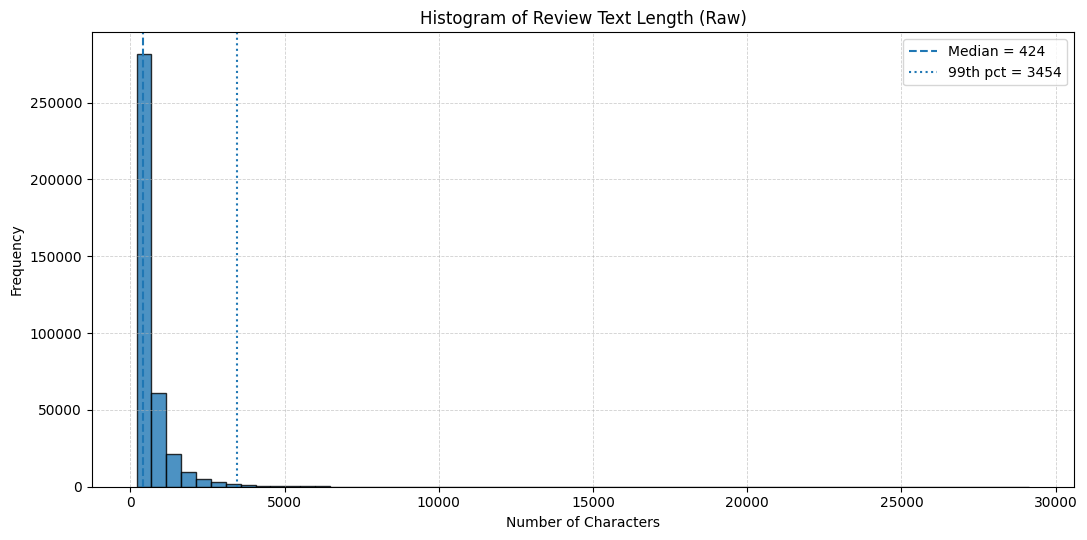

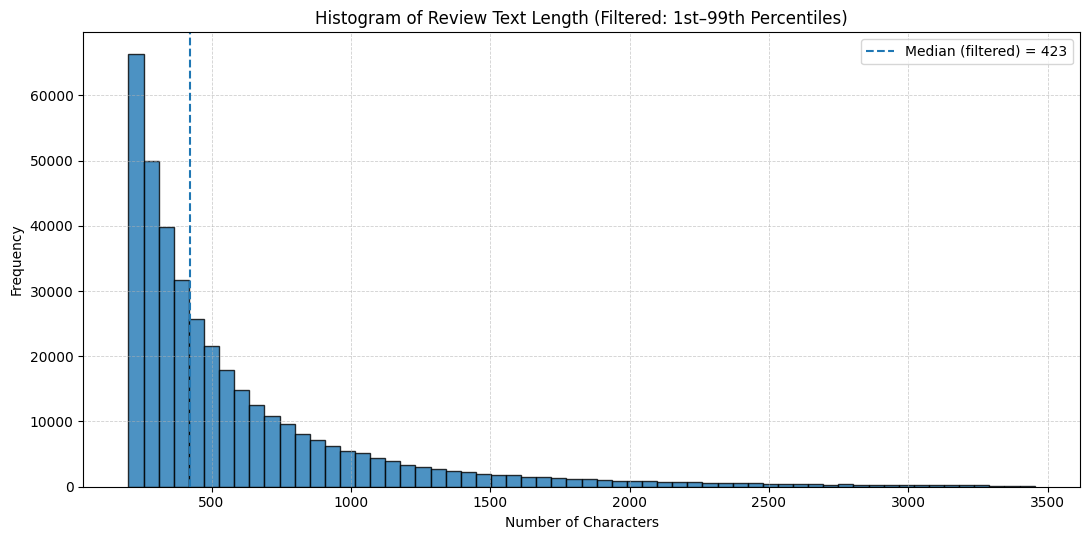

In [19]:
from collections import Counter

# 1) Compute text length
# Ensure 'reviewText' is string; then compute character length.
df['text_length'] = df['reviewText'].astype(str).apply(len)

# ------------------------------
# 2) Summary stats (before filtering)
# ------------------------------
min_len = df['text_length'].min()
max_len = df['text_length'].max()
mean_len = df['text_length'].mean()
median_len = df['text_length'].median()
p01 = df['text_length'].quantile(0.01)
p99 = df['text_length'].quantile(0.99)

print(f"Min length: {min_len}")
print(f"Max length: {max_len}")
print(f"Mean length: {mean_len:.2f}")
print(f"Median length: {median_len:.0f}")
print(f"1st percentile: {p01:.0f}")
print(f"99th percentile: {p99:.0f}")

# ------------------------------
# 3) Raw distribution plot
# ------------------------------
plt.figure(figsize=(11, 5.5))
# Slightly more bins for smoother shape; edgecolor improves readability.
plt.hist(df['text_length'], bins=60, edgecolor='black', alpha=0.8)
plt.title('Histogram of Review Text Length (Raw)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)

# Helpful reference lines: median and 99th percentile
plt.axvline(median_len, linestyle='--', linewidth=1.5, label=f"Median = {int(median_len)}")
plt.axvline(p99, linestyle=':', linewidth=1.5, label=f"99th pct = {int(p99)}")
plt.legend()
plt.tight_layout()
plt.show()

# 4) Filter out extreme outliers (1% tails)
lower_limit = p01
upper_limit = p99
df_filtered = df[(df['text_length'] >= lower_limit) & (df['text_length'] <= upper_limit)]

# 5) Distribution after filtering
plt.figure(figsize=(11, 5.5))
plt.hist(df_filtered['text_length'], bins=60, edgecolor='black', alpha=0.8)
plt.title('Histogram of Review Text Length (Filtered: 1st–99th Percentiles)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)

# Recompute median on filtered data for reference
median_filtered = df_filtered['text_length'].median()
plt.axvline(median_filtered, linestyle='--', linewidth=1.5, label=f"Median (filtered) = {int(median_filtered)}")
plt.legend()
plt.tight_layout()
plt.show()

##✂️Truncating Review Texts for Transformer Compatibility

 Text truncation applied successfully!
New min length: 200
New max length: 2000
New mean length: 596.56
New median length: 424.0


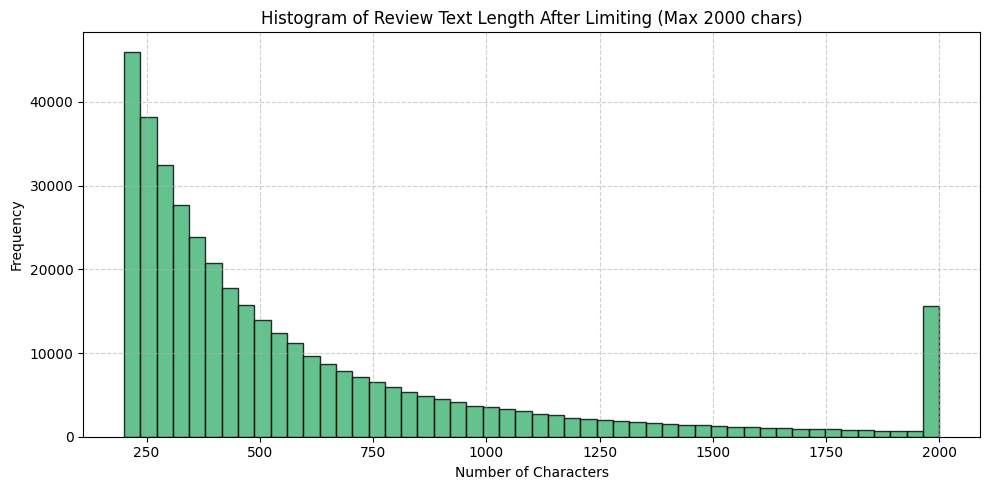

In [20]:
#  Step 1: Define the maximum allowed character length
# Most BERT-family models (RoBERTa, DistilBERT, DeBERTa)
# handle up to ~512 tokens, which ≈ 2000–2500 characters.

MAX_CHARS = 2000

#  Step 2: Truncate long reviews safely
# Convert all entries to string (in case of NaN)
# and cut off any review beyond MAX_CHARS.
df['reviewText'] = df['reviewText'].astype(str).str[:MAX_CHARS]

#  Step 3: Recalculate and verify new text lengths

df['text_length'] = df['reviewText'].apply(len)

print(" Text truncation applied successfully!")
print("New min length:", df['text_length'].min())
print("New max length:", df['text_length'].max())
print("New mean length:", round(df['text_length'].mean(), 2))
print("New median length:", df['text_length'].median())

#  Step 4: Optional – visualize new distribution

plt.figure(figsize=(10, 5))
plt.hist(df['text_length'], bins=50, color='mediumseagreen', edgecolor='black', alpha=0.8)
plt.title(f"Histogram of Review Text Length After Limiting (Max {MAX_CHARS} chars)")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Saving the balanced-truncated dataset as csv for further use and preprocess

In [21]:
from google.colab import drive
drive.mount('/content/drive')

# Save to Google Drive
df.to_csv("/content/drive/MyDrive/balanced_truncated_dataset.csv", index=False)

print("File saved to Google Drive as 'balanced_truncated_dataset.csv' succesfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File saved to Google Drive as 'balanced_truncated_dataset.csv' succesfully!
